In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Make clicks stimulus

In [2]:
def rate_from_gamma(gamma, total_rate=40):
    left = total_rate / (np.exp( gamma) + 1);
    right = total_rate - left;
    return left, right

In [16]:
def make_clicktrain(total_rate=40, gamma=1.5, duration=.5, dt=.001, stereo_click=True):
    """Generate Poisson Click train"""
    tvec = np.arange(0, duration, dt)
    left_rate, right_rate = rate_from_gamma(gamma, total_rate)
    left_rate = total_rate - right_rate
    right_ind = np.random.random_sample(np.shape(tvec)) < (right_rate * dt)
    left_ind = np.random.random_sample(np.shape(tvec)) < (left_rate * dt)    
    
    if stereo_click:
        first_ind = np.argwhere(right_ind+left_ind>0)[0]
        right_ind[first_ind] = 1
        left_ind[first_ind] = 1
    
    left_bups = tvec[left_ind]
    right_bups = tvec[right_ind]
    
    fig, ax = plt.subplots( figsize=(4,2.5))
    ax1 = ax
    ax1.eventplot(left_bups,lineoffsets=-.5,color="blue", alpha=.5)
    ax1.eventplot(right_bups,lineoffsets=.5,color="red", alpha=.5)
    ax1.plot(left_bups,-np.ones_like(left_bups), "o", color="blue", alpha=.5, label=f"r_L={left_rate:.2f} Hz")
    ax1.plot(right_bups,np.ones_like(right_bups), "o", color="red", alpha=.5, label=f"r_R={right_rate:.2f} Hz")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Clicks")
    ax1.legend(loc="upper center", ncol=2, bbox_to_anchor=(.5 ,1.25))
    ax1.set_xlim([0, duration])
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    bups = {'left':left_bups, 'right':right_bups, 'tvec':tvec, 
            'right_ind':right_ind, 'left_ind':left_ind, 'duration':duration}
    
    return bups

In [27]:
# adapt the clicks
def make_adapted_clicks(bups, phi=.1, tau_phi=.2, cross_stream=True):
    if not cross_stream:
        raise notImplementedError
    if phi > 1:
        raise notImplementedError

    # concatenate left and right bups to get interclick intervals
    left_bups = bups['left']
    right_bups = bups['right']
    bups_cat = np.hstack([left_bups, right_bups])
    sign_cat = np.hstack([-np.ones_like(left_bups), np.ones_like(right_bups)])
    sort_order = np.argsort(bups_cat)
    bups_cat = bups_cat[sort_order]
    sign_cat = sign_cat[sort_order]
    ici = np.diff(bups_cat)
    
    C  = np.ones_like(bups_cat)
    cross_side_suppression = 0
    for ii in np.arange(1,len(C)):
        if ici[ii-1] <= cross_side_suppression and phi != 1:
            C[ii-1] = 0
            C[ii] = 0
            continue
        if abs(phi-1) > 1e-5:
            style = 'bing'
            if style=='bing':
                last = tau_phi  * np.log(abs(1 - C[ii-1] * phi))
                C[ii] = 1 - np.exp((-ici[ii-1] + last) / tau_phi)
            if style=='brian':
                arg = (1/tau_phi) * (-ici[ii-1] + sp.special.xlogy(tau_phi, abs(1.-C[ii-1]*phi)))
                if C[ii]*phi <=1:
                    C[ii] = 1. - np.exp(arg) 
                else:
                    C[ii] = 1. + np.exp(arg) 
    left_adapted = C[sign_cat==-1]
    right_adapted = C[sign_cat==1]
    bups['left_adapted'] = left_adapted
    bups['right_adapted'] = right_adapted
    
    # compute the full adaptation process
    tvec = bups['tvec']
    dt = np.mean(np.diff(tvec))
    Cfull = np.ones_like(tvec)

    for (ii, tt) in enumerate(tvec[:-1]):
        thislb = bups['left_ind'][ii] * 1.
        thisrb = bups['right_ind'][ii] * 1.
        if thislb + thisrb == 2. and phi != 1:
            Cfull[ii] = 0
        Cdot =  (1-Cfull[ii]) / tau_phi * dt + (phi - 1) * Cfull[ii] * (thislb + thisrb)
        Cfull[ii+1] = Cfull[ii] + Cdot

    fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)
    ax0 = ax[0]
    ax1 = ax[1]
    ax0.plot(tvec, Cfull, color = "gray")
    ax0.plot(left_bups, left_adapted, "o", color="blue", alpha=.5)
    ax0.plot(right_bups, right_adapted, "o", color="red", alpha=.5)
    ax0.set_ylabel("Adaptation value, C")
    
    ax1.plot(np.vstack([left_bups, left_bups]), 
             np.vstack([np.zeros_like(left_bups), -left_adapted]), color="blue", alpha=.5)
    ax1.plot(np.vstack([right_bups, right_bups]), 
             np.vstack([np.zeros_like(right_bups), right_adapted]), color="red", alpha=.5)
    
    ax1.plot(left_bups,-left_adapted, "o", color="blue", alpha=.5)
    ax1.plot(right_bups,right_adapted, "o", color="red", alpha=.5)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Adapted clicks")

    sns.despine()
    plt.tight_layout()

    plt.show()
    
    return None

# Generate click trains
The left and right Poisson Click trains, $\delta_{t,t_L}$ and $\delta_{t,t_R}$ are generated by sampling at two different Poisson rates $r_L$ and $r_R$. 

These generative click rates are determined by setting the overall total rate (default value is 40Hz) and the contrast parameter $\gamma = \log \frac{r_R}{r_L}$.


In [28]:
w = interactive(make_clicktrain, #{'manual': True},
                gamma=(-5,5,.25), duration=(0,9,.1), dt=(.001,.1,.01), total_rate=(5,40,5))
display(w)

interactive(children=(IntSlider(value=40, description='total_rate', max=40, min=5, step=5), FloatSlider(value=…

# Apply click adaptation
$\frac{dC}{dt} = \frac{1-C}{\tau_{\phi}} + (\phi - 1) C (\delta_{t,t_R} + \delta_{t,t_L})$

In [29]:
bups = w.result
w2 = interactive(make_adapted_clicks, #{'manual': True},
                bups=fixed(bups), phi=(0.01,1.2,.01), tau_phi=(.001,1,.01))
display(w2)

interactive(children=(FloatSlider(value=0.1, description='phi', max=1.2, min=0.01, step=0.01), FloatSlider(val…

# Integrate the adapted clicks
Now, we need to integrate the adapted clicks. We'll also apply per-click noise (aka sensory noise) with standard deviation $\sigma_s$, memory noise with s.d.=$\sigma_a$, initial noise with s.d.=$\sigma_i$, and an integration time constant $\lambda$. This gives us our accumulation value
\begin{align}
da &= (\eta C \delta_R - \eta C \delta_L)dt + \lambda a dt + \sigma_adW , & a_0 = \mathcal{N}(0, \sigma_i^2)
\end{align}

In [52]:
len(np.argwhere(np.array([0, 1])>=3))

0

interactive(children=(FloatSlider(value=0.0, description='lam', max=10.0, min=-10.0, step=0.25), FloatSlider(v…

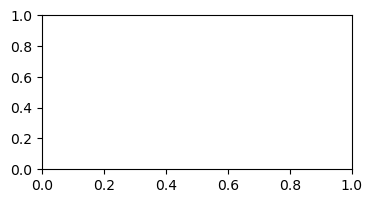

In [53]:
def integrate_adapted_clicks(bups, lam=0, s2s=0.001, s2a=.001, s2i=.001, bias=0, B=10., nagents=5):
    tvec = bups['tvec']
    fig, ax = plt.subplots(figsize=(4,2))
    dt = np.mean(np.diff(tvec))
    dur = bups['duration']
    
    left_adapted = bups['left_adapted'].copy()
    right_adapted = bups['right_adapted'].copy()
    left_ts = bups['left']
    right_ts = bups['right']
    left_adapted *= np.exp(lam * (dur - left_ts))
    right_adapted *= np.exp(lam * (dur - right_ts))
    
    for agenti in np.arange(nagents):
        left_vals = np.zeros_like(tvec) 
        right_vals = np.zeros_like(tvec)
        
        left_noise = np.random.normal(1, np.sqrt(s2s), np.shape(left_adapted)) 
        left_noise *= np.exp(2*lam*(dur-left_ts))
        right_noise = np.random.normal(1, np.sqrt(s2s), np.shape(right_adapted)) 
        right_noise *= np.exp(2*lam*(dur-right_ts))
        
        left_vals[bups['left_ind']] =  left_adapted * left_noise
        right_vals[bups['right_ind']] = right_adapted * right_noise
        
        memory_noise = np.random.normal(0, np.sqrt(s2a) * np.sqrt(dt), np.shape(tvec)) 
        memory_noise *= np.exp(2*lam*(dur-tvec))

        init_noise = np.random.normal(0, np.sqrt(s2i), 1)*np.exp(2*lam*dur)

        a = np.cumsum(right_vals) - np.cumsum(left_vals) + memory_noise + init_noise
        
#         crossing = np.argwhere(abs(a)>B)
#         if len(crossing ) > 0:
#             ii = crossing[0]
#             a[ii:] = a[ii]
        
        ax.plot(tvec, a, color="gray")
    
    
    ax.axhline(bias,color='black',linestyle='--')
    ax.set_xlabel("Time")
    ax.set_ylabel("Accumulation value, a")
    sns.despine()
    plt.show()
    return a


a = interactive(integrate_adapted_clicks, #{'manual': True},
                bups=fixed(bups), lam =(-10,10,.25), s2s=(0.001,10,.25), s2a=(.001, 5, .25), s2i=(.001,5,.1),
               bias=((-5,5,.1)), nagents=(1,10))
display(a)

In [8]:
# TODO Make the bups stay synced when it changes

In [9]:
# TODO Make adaptation work for positive values of phi
# TODO Add tests for adaptation process

In [10]:
# TODO add the time constant
# TODO add some noise
# TODO fix the noise units


In [11]:
# make tests
# put it on the internet 
# https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916


In [12]:
# add multiple trials
# add a bound